# Data loading and processing

In [1]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor

%matplotlib inline

In [2]:
#Loading train and test data (test set for competition will be called evaluate)
data = pd.read_csv('train.csv', index_col = 'Id')
evaluate = pd.read_csv('test.csv', index_col = 'Id')

In [3]:
#appending both sets to be sure, that made changes whould be the same
full = data.append(evaluate, ignore_index=False, sort = False)

## Features engineering

In [4]:
#creating three typeas of variables: qualitive (only for factorization), 
#ordinal (to change names so that bigger number is better) and quantitive (no need for change)
qualitive = ['MSSubClass', 'MSZoning', 'BldgType', 'Heating',
             'GarageType', 'GarageFinish', 
                 'SaleType', 'SaleCondition',
                'Foundation', 'Fence']

ordinal = ['Street', 'LotShape', 'Basement', 'AfterRemod', 'Utilities', 'LandSlope', 'KitchenQual', 'PavedDrive', 
                'CentralAir', 'PoolQC']
    
quantitive = ['LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'GarageArea', 
             'MiscVal', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 
              'Pool_QC_Area', 'Garage_QC_Area', 'LotFrontage', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', '1stFlrSF',
             'FullBath', 'TotRmsAbvGrd']




In [5]:
for i in qualitive:
    full[i] = full[i].factorize()[0]

In [6]:
full['Basement'] = full['BsmtQual'].notnull().map({True: 1, False: 0})

In [7]:
full['AfterRemod'] = full['YearBuilt'].where(full['YearBuilt'] == full['YearRemodAdd']).isna().map({True: 1, False: 0})

In [8]:
full['GarageArea'] = full['GarageArea'].fillna(0)

In [9]:
full['KitchenQual'] = full['KitchenQual'].map({'Fa': 0,
                    'TA': 1, 
                    'Gd': 2, 
                    'Ex': 3})
full['KitchenQual'] = full['KitchenQual'].fillna(0)

In [10]:
full['Street'] = full['Street'].map({'Grvl': 0,
                    'Pave': 1})

In [11]:
full['LotShape'] = full['LotShape'].map({'IR3': 0,
                    'IR2': 1, 
                    'IR1': 2, 
                    'Reg': 3})

In [12]:
full['Utilities'] = full['Utilities'].map({'AllPub': 1,
                    'NoSeWa': 0})
full['Utilities'] = full['Utilities'].fillna(0)

In [13]:
full['LandSlope'] = full['LandSlope'].map({'Sev': 0,
                    'Mod': 1, 
                    'Gtl': 2})

In [14]:
full['PavedDrive'] = full['PavedDrive'].map({'N': 0,
                    'P': 1, 
                    'Y': 2})

In [15]:
full['CentralAir'] = full['CentralAir'].map({'N': 0,
                    'Y': 1})

In [16]:
full['PoolQC'] = full['PoolQC'].map({'Fa': 1,
                    'TA': 2, 
                    'Gd': 3, 
                    'Ex': 4})
full['PoolQC'] = full['PoolQC'].fillna(0)

In [17]:
full['Pool_QC_Area'] = full['PoolQC'] * full['PoolArea']

In [18]:
full['GarageQual'] = full['GarageQual'].map({'Po': 1, 
                    'Fa': 2,
                    'TA': 3, 
                    'Gd': 4, 
                    'Ex': 5})
full['GarageQual'] = full['GarageQual'].fillna(0)

In [19]:
full['Garage_QC_Area'] = full['GarageQual'] * full['GarageArea']

In [20]:
 full['LotFrontage'] = full['LotFrontage'].fillna(0)

In [21]:
 full['GarageCars'] = full['GarageCars'].fillna(0)

In [22]:
 full['FullBath'] = full['FullBath'].fillna(0)

In [23]:
 full['TotRmsAbvGrd'] = full['TotRmsAbvGrd'].fillna(0)

In [24]:
 full['1stFlrSF'] = full['1stFlrSF'].fillna(0)

In [25]:
 full['TotalBsmtSF'] = full['TotalBsmtSF'].fillna(0)

## Sets

In [26]:
#joining all needen columns in one DataFrame
full = full[qualitive].join(full[quantitive]).join(full[ordinal]).join(full['SalePrice'])

In [27]:
#division of trainging and evaluate sets
data = full[full['SalePrice'].isna() == False]
evaluate = full[full['SalePrice'].isna() == True].drop(labels = 'SalePrice', axis = 1)

In [28]:
#removing outliers and leverage values
mean = data.describe().loc['mean', 'SalePrice']
std = data.describe().loc['std', 'SalePrice']
data = data[data['SalePrice'] < (mean + 5*std)]

In [29]:
#creating X and y sets
y = data['SalePrice']
X = data.drop(labels = 'SalePrice', axis = 1)

In [30]:
#division of sets for training and scoring
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

# Decision Tree with GridSearchCV

In [31]:
#using GridSearchCV module to find best hiperparameters for Decision Tree with usage of Cross Validation
tree_estimator = DecisionTreeRegressor(random_state = 1)
tree_param_grid = {'max_depth': range(1, 5),
              'min_samples_leaf': range (1, 10),
             'min_samples_split': range (2, 10)}
grid_tree = GridSearchCV(estimator=tree_estimator, param_grid=tree_param_grid, cv=3, n_jobs=4)
grid_tree.fit(X=X_train, y=y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=1, splitter='best'),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid={'max_depth': range(1, 5), 'min_samples_leaf': range(1, 10), 'min_samples_split': range(2, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [32]:
#checking the best hiperparameters
best_params = pd.Series(grid_tree.best_params_)
best_params

max_depth            4
min_samples_leaf     6
min_samples_split    2
dtype: int64

In [33]:
#model scoring
grid_tree_score = grid_tree.score(X=X_test, y=y_test)
grid_tree_score

0.7572046020353111

# Bagging

In [34]:
#Training Decistion Tree with Bagging
bag = BaggingRegressor(n_estimators=200, n_jobs=4, random_state=1)
bag.fit(X=X_train, y=y_train)

BaggingRegressor(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=200, n_jobs=4, oob_score=False, random_state=1,
         verbose=0, warm_start=False)

In [35]:
bag_score = bag.score(X_test, y_test)
bag_score

0.8775642367580626

# Bosting with GridSearchCV

In [36]:
#Using GridSearch to find the best hiperparameters fot GradientBoostRegressor
boost_param_grid = {'n_estimators': range(100, 500, 100),
                   'learning_rate': np.arange(0.01, 0.1, 0.02)}
boost_estimator = GradientBoostingRegressor(random_state=1)
boost_grid = GridSearchCV(param_grid=boost_param_grid, estimator = boost_estimator, cv=4, n_jobs=4)

In [37]:
#Model training
boost_grid.fit(X=X_train, y=y_train)

GridSearchCV(cv=4, error_score='raise-deprecating',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_sampl...ate=1, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid={'n_estimators': range(100, 500, 100), 'learning_rate': array([0.01, 0.03, 0.05, 0.07, 0.09])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [38]:
#check of score
boost_grid_score = boost_grid.score(X_test, y_test)
boost_grid_score

0.8920313596945827

In [39]:
#check of best hiperparameters
pd.Series(boost_grid.best_params_)

learning_rate      0.05
n_estimators     300.00
dtype: float64

# Boosting

In [40]:
#Training Decistion Tree with Boosting
boost = GradientBoostingRegressor(n_estimators=300, learning_rate=0.05, random_state=1)
boost.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=300, n_iter_no_change=None, presort='auto',
             random_state=1, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [41]:
boost_score = boost.score(X_test, y_test)
boost_score

0.8923051258776783

# Random forest

In [42]:
#Random Forest training using the best hiperparameters
sqrt = int(np.sqrt(len(X_train.columns)))
forest = RandomForestRegressor(max_depth=best_params['max_depth'],
                              min_samples_leaf = best_params['min_samples_leaf'],
                              min_samples_split = best_params['min_samples_split'], n_estimators=100, random_state = 1,
                              bootstrap=True, max_features=sqrt, n_jobs=4)
forest.fit(X=X_train, y=y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=4,
           max_features=6, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=6,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=4, oob_score=False, random_state=1,
           verbose=0, warm_start=False)

In [43]:
forest_score = forest.score(X=X_test, y=y_test)
forest_score

0.8064227690081869

In [44]:
#checking importance of used variables
feature_importances = pd.Series(forest.feature_importances_, X_train.columns).sort_values(ascending=False)
feature_importances.head()

OverallQual    0.160376
GrLivArea      0.142118
GarageCars     0.085920
FullBath       0.082847
YearBuilt      0.076559
dtype: float64

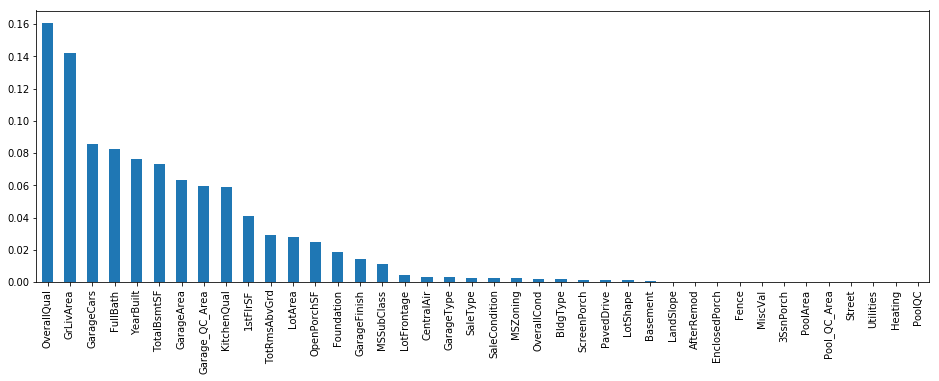

In [45]:
feature_importances.plot(kind = 'bar', figsize=(16, 5))

## Least square regression

In [46]:
#preparing datasets for Linear Regression (only ordinal and quantitive data)
X_train_lin = X_train[quantitive].join(X_train[ordinal])
X_test_lin = X_test[quantitive].join(X_test[ordinal])

In [47]:
#Linear Regression using Least Square Method
square = LinearRegression(fit_intercept=True, copy_X=True, n_jobs = 4)
square.fit(X_train_lin,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=4, normalize=False)

In [48]:
square_score = square.score(X_test_lin,y_test)
square_score

0.8569025748824364

In [49]:
#checking coefficients
square.intercept_

-1073633.1729438643

In [50]:
#coefficients of the model
pd.Series(square.coef_, X_train_lin.columns)

LotArea                0.611871
OverallQual        16267.420931
OverallCond         4469.803245
YearBuilt            481.100041
GarageArea           -55.564982
MiscVal               -0.066543
OpenPorchSF           -1.078794
EnclosedPorch         39.647113
3SsnPorch             -7.088101
ScreenPorch           76.134150
PoolArea             -91.307562
Pool_QC_Area         487.536347
Garage_QC_Area        24.610609
LotFrontage           24.244027
GrLivArea             35.694983
GarageCars          8018.042477
TotalBsmtSF           27.957952
1stFlrSF               2.041989
FullBath           -4887.115201
TotRmsAbvGrd        2595.350379
Street             19908.900785
LotShape           -3358.688368
Basement          -19865.732717
AfterRemod          9848.576835
Utilities          51246.885393
LandSlope          -7488.727602
KitchenQual        14225.782998
PavedDrive          1084.905154
CentralAir         -3183.944471
PoolQC           -292459.028196
dtype: float64

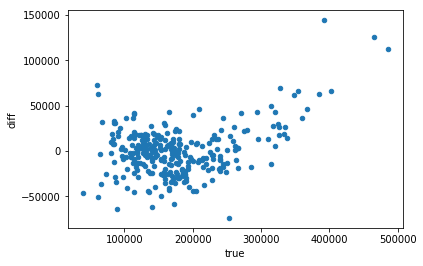

In [51]:
#creating a graph with residual values
prediction = square.predict(X = X_test_lin)
compare = pd.DataFrame({'prediction': prediction, 'true': y_test, 'diff': (y_test - prediction)})
compare.plot.scatter( x = 'true', y = 'diff')

# Ridge Regression

In [79]:
#Scaling variables
scaler = StandardScaler()
X_lin = X[quantitive].join(X[ordinal])
scaler.fit(X_lin)

X_scaled = scaler.transform(X_lin)
X_scaled = pd.DataFrame(X_scaled, columns = X_lin.columns)
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y, test_size = 0.2, random_state = 1)

C:\Users\Mateusz Bujalski\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Mateusz Bujalski\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


In [53]:
#Linear Regression using Ridge Method
ridge = Ridge(fit_intercept=True, random_state=1, alpha=1)
ridge.fit(X_train_scaled, y_train_scaled)

Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=1, solver='auto', tol=0.001)

In [54]:
ridge_score = ridge.score(X = X_test_scaled, y = y_test_scaled)
ridge_score

0.856724884153603

In [55]:
ridge.intercept_

179247.52113259205

In [56]:
#coefficients of the model
pd.Series(ridge.coef_, X_train_scaled.columns)

LotArea            6088.534381
OverallQual       22290.687972
OverallCond        4986.025818
YearBuilt         14480.224816
GarageArea       -11223.593181
MiscVal             -41.037358
OpenPorchSF         -10.805889
EnclosedPorch      2367.004707
3SsnPorch          -205.992444
ScreenPorch        4211.625574
PoolArea          -3079.406774
Pool_QC_Area      45895.591362
Garage_QC_Area    15618.531379
LotFrontage         761.552745
GrLivArea         17991.784781
GarageCars         6046.910010
TotalBsmtSF       11781.959134
1stFlrSF           1060.764327
FullBath          -2590.345534
TotRmsAbvGrd       4260.593747
Street             1275.878289
LotShape          -1946.998014
Basement          -2994.554860
AfterRemod         4886.691527
Utilities          1356.609150
LandSlope         -2087.028402
KitchenQual        9419.092257
PavedDrive          553.386829
CentralAir         -780.033798
PoolQC           -48339.223644
dtype: float64

## Lasso Regression

In [57]:
#Linear Regression using Lasso Method
lasso = Lasso(fit_intercept=True, copy_X=True, random_state=1, max_iter=50000, alpha=4)
lasso.fit(X=X_train_scaled, y=y_train_scaled)

Lasso(alpha=4, copy_X=True, fit_intercept=True, max_iter=50000,
   normalize=False, positive=False, precompute=False, random_state=1,
   selection='cyclic', tol=0.0001, warm_start=False)

In [58]:
lasso_score = lasso.score(X=X_test_scaled, y=y_test_scaled)
lasso_score

0.8569611565075915

In [59]:
lasso.intercept_

179249.82849583123

In [60]:
#coefficients of the model
pd.Series(lasso.coef_, X_train_scaled.columns)

LotArea            6095.148947
OverallQual       22283.736287
OverallCond        4974.761832
YearBuilt         14500.296941
GarageArea       -11477.198932
MiscVal             -30.755199
OpenPorchSF         -59.334986
EnclosedPorch      2408.747843
3SsnPorch          -204.444430
ScreenPorch        4228.140796
PoolArea          -3372.788098
Pool_QC_Area      48829.049086
Garage_QC_Area    15954.984350
LotFrontage         826.509584
GrLivArea         18206.200650
GarageCars         5938.616422
TotalBsmtSF       12087.219230
1stFlrSF            812.349021
FullBath          -2643.560478
TotRmsAbvGrd       4170.073394
Street             1272.341908
LotShape          -1954.852854
Basement          -3106.704262
AfterRemod         4905.451476
Utilities          1341.144067
LandSlope         -2070.015751
KitchenQual        9390.996567
PavedDrive          539.769961
CentralAir         -773.673080
PoolQC           -51055.076035
dtype: float64

## K-Nearest Neighbours with GridSearchCV

In [61]:
#chosing most important features basing on feature_importance from Random Forest estimator
feat_neighb = feature_importances.nlargest(10).index.to_list()

X_train_neighb = X_train_scaled[feat_neighb]
X_test_neighb = X_test_scaled[feat_neighb]

In [62]:
#Using GridSearch to find the best hiperparameters fot GradientBoostRegressor
neighbours_param_grid = {'n_neighbors': range(1, 30)}
neighbors_estimator = KNeighborsRegressor()
neighbours_grid = GridSearchCV(param_grid=neighbours_param_grid, estimator=neighbors_estimator, cv=4, n_jobs=4)

In [63]:
#model training
neighbours_grid.fit(X_train_neighb, y_train_scaled)

GridSearchCV(cv=4, error_score='raise-deprecating',
       estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=5, p=2,
          weights='uniform'),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid={'n_neighbors': range(1, 30)}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring=None, verbose=0)

In [64]:
#check of best hiperparameter
neighbours_grid.best_params_

{'n_neighbors': 10}

In [65]:
#check of score
neighbours_grid_score = neighbours_grid.score(X_test_neighb, y_test_scaled)
neighbours_grid_score

0.8536948494103186

## DummyRegressor

In [66]:
#comparing obtained scores with score from Dummy Regressor
dummy = DummyRegressor(strategy='mean')
dummy.fit(X=X_train, y=y_train)

DummyRegressor(constant=None, quantile=None, strategy='mean')

In [67]:
dummy.score(X = X_test, y=y_test)

-0.0027327000850954075

## Predictions for test data

In [68]:
#collecting scores of all created models
scores = pd.Series({'grid_tree': grid_tree_score,
'forest': forest_score,
'square': square_score,
'lasso': lasso_score,
'ridge': ridge_score,
'bag': bag_score,
'boost_grid': boost_grid_score,
'neighbours_grid': neighbours_grid_score})
scores.sort_values(ascending = False)

boost_grid         0.892031
bag                0.877564
lasso              0.856961
square             0.856903
ridge              0.856725
neighbours_grid    0.853695
forest             0.806423
grid_tree          0.757205
dtype: float64

In [69]:
scores.idxmax()

'boost_grid'

In [82]:
#below are transformations of evaluate set needed for particular estimators (as this set need to be 
#transformed in the same way, as training set) - proper set will be used depending on used estimator

#change of evaluate set for linear models (only ordinal and quantitive features)

evaluate_lin = evaluate[quantitive].join(evaluate[ordinal])

#change of evaluate set needed for estimators with scaled training set

evaluate_scaled = pd.DataFrame(scaler.transform(evaluate_lin), columns = X_lin.columns)

#change of evaluate set needed for K-nearest Neighbours estimator (as not all features were used)

evaluate_neigh = evaluate_scaled[feat_neighb]

C:\Users\Mateusz Bujalski\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  # Remove the CWD from sys.path while we load stuff.


In [103]:
#creating file for submission using model with the best score
predict = boost_grid.predict(X = evaluate)

In [104]:
results = pd.DataFrame({'Id': evaluate.index,
                        'SalePrice': predict})

In [105]:
results = results.set_index(keys = 'Id')

In [106]:
results.to_csv('submission.csv')